<a href="https://colab.research.google.com/github/Simurgh818/mutual_information_analysis/blob/main/NeuralMI_tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import sys
from google.colab import drive

In [2]:
drive.mount('/content/gdrive/')
sys.path.append("/content/gdrive/MyDrive/Data/New Data")

Mounted at /content/gdrive/


In [3]:
pwd

'/content'

In [4]:
cd /content/gdrive/MyDrive/

/content/gdrive/MyDrive


In [5]:
# !git clone https://github.com/eslam-abdelaleem/NeuralMI.git

In [6]:
cd NeuralMI

/content/gdrive/MyDrive/NeuralMI


In [7]:
!pip install .

Processing /content/gdrive/MyDrive/NeuralMI
  Preparing metadata (setup.py) ... done
  Created wheel for neural_mi: filename=neural_mi-1.1.0-py3-none-any.whl size=73085 sha256=00e49abdde74291895425cccb069f7d8364e8d19bc56992c799f111906c9be4d
  Stored in directory: /tmp/pip-ephem-wheel-cache-4orlk7sn/wheels/09/e4/fa/4893e61b6354e596d1073fd2df8c3897800aa6ca14317e9a52
Successfully built neural_mi


In [8]:
!pip install "mne[hdf5]"

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 60.5 MB/s eta 0:00:00


# 1. Load the dataset:

Import EEG data from '/content/gdrive/MyDrive/Data/New Data/EEG epoched' for conditions BLA, BLT, P1, P2, and P3, select channels C3 and CP1, and calculate the mutual information between these channels using the `neural_mi` library from '/content/gdrive/MyDrive/NeuralMI'.

**Reasoning**:
Import the necessary libraries for loading EEG data and calculating mutual information.



In [9]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import os
import torch # Import torch
from tqdm.auto import tqdm
import mne
import neural_mi as nmi
from neural_mi.visualize.plot import plot_cross_correlation, analyze_mi_heatmap

In [10]:
import os

base_directory_path = '/content/gdrive/MyDrive/Data/New Data/EEG epoched/'
conditions = ['BLA', 'BLT', 'P1', 'P2', 'P3']

for condition in conditions:
    directory_path = os.path.join(base_directory_path, condition)
    try:
        files = os.listdir(directory_path)
        print(f"Files in {directory_path}: {files}")
    except FileNotFoundError:
        print(f"Directory not found: {directory_path}")


Files in /content/gdrive/MyDrive/Data/New Data/EEG epoched/BLA: ['binepochs filtered ICArej BLAAvgBOS16.fdt', 'binepochs filtered ICArej BLAAvgBOS5.fdt', 'binepochs filtered ICArej BLAAvgBOS15.set', 'binepochs filtered ICArej BLAAvgBOS11.set', 'binepochs filtered ICArej BLAAvgBOS6.fdt', 'binepochs filtered ICArej BLAAvgBOS17.set', 'binepochs filtered ICArej BLAAvgBOS5.set', 'binepochs filtered ICArej BLAAvgBOS12.set', 'binepochs filtered ICArej BLAAvgBOS2.set', 'binepochs filtered ICArej BLAAvgBOS9.fdt', 'binepochs filtered ICArej BLAAvgBOS3.fdt', 'binepochs filtered ICArej BLAAvgBOS13.fdt', 'binepochs filtered ICArej BLAAvgBOS2.fdt', 'binepochs filtered ICArej BLAAvgBOS8.set', 'binepochs filtered ICArej BLAAvgBOS15.fdt', 'binepochs filtered ICArej BLAAvgBOS7.fdt', 'binepochs filtered ICArej BLAAvgBOS3.set', 'binepochs filtered ICArej BLAAvgBOS10.fdt', 'binepochs filtered ICArej BLAAvgBOS8.fdt', 'binepochs filtered ICArej BLAAvgBOS12.fdt', 'binepochs filtered ICArej BLAAvgBOS7.set', 'b

## 2. Find appropriate window size and lag for Somatosensory Cortex C3 to CP1

### 2.1 **Optimum Window Size Test**: Test window sizes from 50 - 500 msec to see which size has the most information for C3 and CP1 in BLT condition trial 1-3.




In [11]:
base_directory_path = '/content/gdrive/MyDrive/Data/New Data/EEG epoched/'
conditions = ['BLT'] # , 'P1'
processed_data = {}
processed_tensors = {} # Dictionary to store tensors

for condition in conditions:
    directory_path = os.path.join(base_directory_path, condition)
    try:
        files = os.listdir(directory_path)
        # Find the file ending with 'BOS2.set'
        target_file = next((f for f in files if f.endswith('BOS2.set')), None)

        if target_file:
            file_path = os.path.join(directory_path, target_file)
            print(f"Loading file: {file_path}")
            epochs = mne.read_epochs_eeglab(file_path, verbose=False)

            # Select only odd epoch indices
            odd_indices = range(1, len(epochs), 2)
            epochs = epochs[odd_indices]


            processed_epochs = epochs.pick(['C3', 'CP1'])
            # Select only the first epoch
            processed_epochs = processed_epochs[0:3]

            processed_data[condition] = processed_epochs

            # Convert data to tensors and store in processed_tensors
            if 'C3' in processed_epochs.ch_names and 'CP1' in processed_epochs.ch_names:
                c3_data = processed_epochs.get_data(picks=['C3']).squeeze()
                cp1_data = processed_epochs.get_data(picks=['CP1']).squeeze()

                # Reshape and convert to tensors
                c3_tensor = torch.from_numpy(c3_data).float().reshape(-1,1)
                cp1_tensor = torch.from_numpy(cp1_data).float().reshape(-1,1)

                processed_tensors[condition] = {'C3': c3_tensor, 'CP1': cp1_tensor}


        else:
            print(f"No file ending with 'BOS2.set' found in {directory_path}. Skipping this condition.")

    except FileNotFoundError:
        print(f"Error: Directory not found at {directory_path}. Skipping this condition.")
    except ValueError as e:
        print(f"Error processing {condition} from {target_file}: {e}. Skipping this condition.")

# Display the processed data info
for condition, epochs in processed_data.items():
    print(f"\nProcessed data for {condition}:")
    print(epochs.info)
    print(f"Number of epochs: {len(epochs)}")
    print(f"Time points per epoch: {epochs.times.shape[0]}")

# Display the processed tensors info
print("\nProcessed Tensors:")
for condition, tensors in processed_tensors.items():
    print(f"Condition: {condition}")
    print(f"  C3 Tensor Shape: {tensors['C3'].shape}")
    print(f"  CP1 Tensor Shape: {tensors['CP1'].shape}")

Loading file: /content/gdrive/MyDrive/Data/New Data/EEG epoched/BLT/binepochs filtered ICArej BLTAvgBOS2.set


/tmp/ipython-input-3643583452.py:16: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  epochs = mne.read_epochs_eeglab(file_path, verbose=False)



Processed data for BLT:
<Info | 8 non-empty values
 bads: []
 ch_names: C3, CP1
 chs: 2 EEG
 custom_ref_applied: False
 dig: 35 items (3 Cardinal, 32 EEG)
 highpass: 0.0 Hz
 lowpass: 256.0 Hz
 meas_date: unspecified
 nchan: 2
 projs: []
 sfreq: 512.0 Hz
>
Number of epochs: 3
Time points per epoch: 1792

Processed Tensors:
Condition: BLT
  C3 Tensor Shape: torch.Size([5376, 1])
  CP1 Tensor Shape: torch.Size([5376, 1])


**Reasoning**:
Create a list of window sizes to iterate through for mutual information calculation.



In [12]:
window_sizes_seconds = np.arange(0.05, 0.55, 0.05).tolist()
print("Window sizes to test (seconds):", window_sizes_seconds)

Window sizes to test (seconds): [0.05, 0.1, 0.15000000000000002, 0.2, 0.25, 0.3, 0.35000000000000003, 0.4, 0.45, 0.5]


In [13]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Using device: {device}")

base_params = {
      'n_epochs': 50, 'learning_rate': 5e-4, 'batch_size': 128,
      'patience': 30, 'embedding_dim': 16, 'hidden_dim': 64, 'n_layers': 2,
      'device': device # Add device to base_params
}

c3_tensor = processed_tensors['BLT']['C3']*1e6
cp1_tensor = processed_tensors['BLT']['CP1']*1e6


window_sweep_grid = {'window_size': range(20, 250, 10)}

results_history = nmi.run(
    x_data=c3_tensor,
    y_data=cp1_tensor,
    mode='sweep',
    processor_type='continuous',
    processor_params={},
    base_params=base_params,
    sweep_grid=window_sweep_grid,
    n_workers=4,
)

Using device: cuda
2025-11-08 14:44:09 - neural_mi - WARNING - `processor_type` is deprecated. Use `processor_type_x` and `processor_type_y` instead.


2025-11-08 14:44:09 - neural_mi - WARNING - `processor_params` is deprecated. Use `processor_params_x` and `processor_params_y` instead.


2025-11-08 14:44:09 - neural_mi - INFO - Detected sweep over processor or lag parameters. Deferring data processing to workers.


INFO:neural_mi:Detected sweep over processor or lag parameters. Deferring data processing to workers.


2025-11-08 14:44:09 - neural_mi - INFO - Starting parameter sweep with 4 workers...


INFO:neural_mi:Starting parameter sweep with 4 workers...


Parameter Sweep Progress:   0%|          | 0/23 [00:00<?, ?task/s]

2025-11-08 14:46:55 - neural_mi - INFO - Parameter sweep finished.


INFO:neural_mi:Parameter sweep finished.


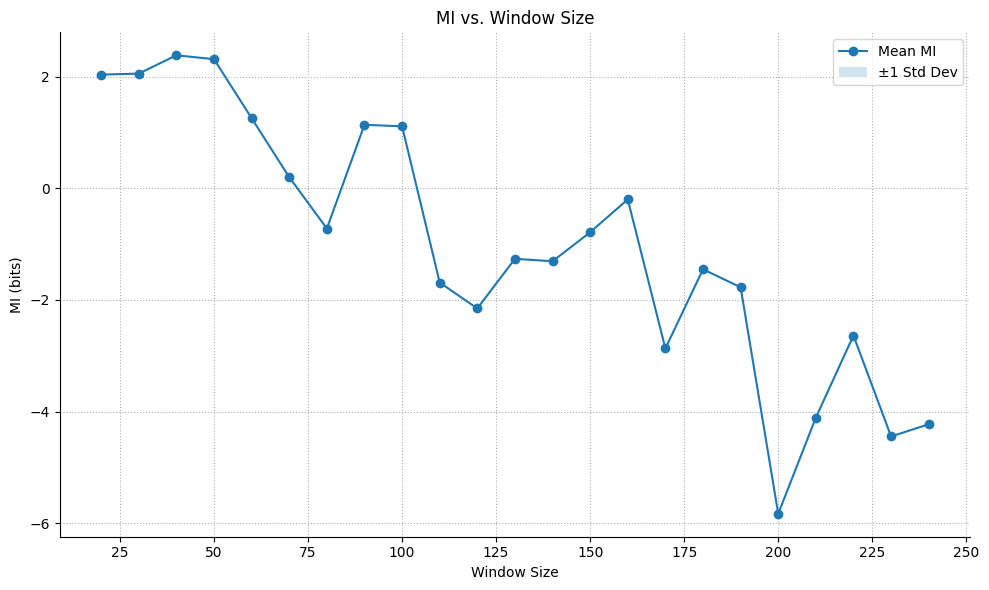

<Axes: title={'center': 'MI vs. Window Size'}, xlabel='Window Size', ylabel='MI (bits)'>

In [14]:
results_history.plot()

The window size between 25 and 50 samples has highest MI.


In [15]:
window_sweep_grid = {'window_size': range(5, 75, 5)} # , 'run_id': range(3)

results_history = nmi.run(
    x_data=c3_tensor,
    y_data=cp1_tensor,
    mode='sweep',
    processor_type='continuous',
    processor_params={},
    base_params=base_params,
    sweep_grid=window_sweep_grid,
    n_workers=4,
)

2025-11-08 14:46:55 - neural_mi - WARNING - `processor_type` is deprecated. Use `processor_type_x` and `processor_type_y` instead.


2025-11-08 14:46:55 - neural_mi - WARNING - `processor_params` is deprecated. Use `processor_params_x` and `processor_params_y` instead.


2025-11-08 14:46:55 - neural_mi - INFO - Detected sweep over processor or lag parameters. Deferring data processing to workers.


INFO:neural_mi:Detected sweep over processor or lag parameters. Deferring data processing to workers.


2025-11-08 14:46:55 - neural_mi - INFO - Starting parameter sweep with 4 workers...


INFO:neural_mi:Starting parameter sweep with 4 workers...


Parameter Sweep Progress:   0%|          | 0/14 [00:00<?, ?task/s]

2025-11-08 14:48:36 - neural_mi - INFO - Parameter sweep finished.


INFO:neural_mi:Parameter sweep finished.


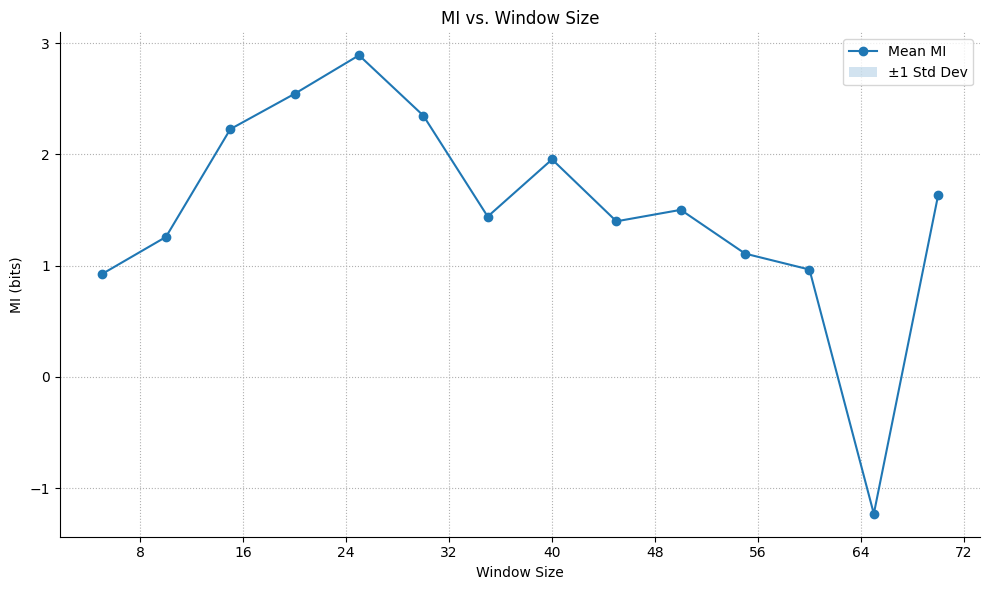

<Axes: title={'center': 'MI vs. Window Size'}, xlabel='Window Size', ylabel='MI (bits)'>

In [16]:
results_history.plot()

In [17]:
results_history.dataframe


,window_size,mi_mean,mi_std
0,5,0.922276,0.0
1,10,1.257878,0.0
2,15,2.227049,0.0
3,20,2.544897,0.0
4,25,2.891229,0.0
5,30,2.348235,0.0
6,35,1.440954,0.0
7,40,1.955106,0.0
8,45,1.398346,0.0
9,50,1.501455,0.0


In [18]:
right_window_size = results_history.dataframe.loc[results_history.dataframe['mi_mean'].idxmax()][0];
right_window_size = int(right_window_size)
display(right_window_size)

/tmp/ipython-input-3706404400.py:1: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  right_window_size = results_history.dataframe.loc[results_history.dataframe['mi_mean'].idxmax()][0];


25

### 2.2: Find appropriate lag between C3 and CP1

In [19]:
# Plotting function for X and Y
def plot_data(x, y, title=None, xlim=1000):
    fig, ax = plt.subplots(figsize=(8, 4))
    ax.plot(x.T, label=r'$x(t)$')
    ax.plot(y.T, label=r'$y(t)$')
    ax.set_xlabel('Timepoints')
    ax.set_ylabel('Value')
    if title:
        ax.set_title(title)
    ax.set_xlim(0, xlim)
    ax.legend()
    plt.show()

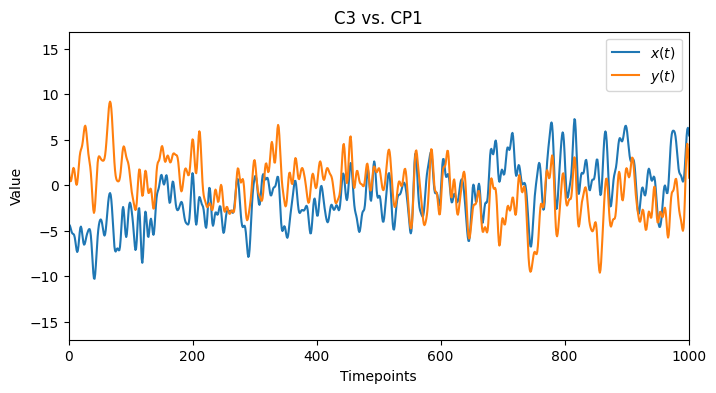

In [20]:
plot_data(c3_tensor.T,cp1_tensor.T, 'C3 vs. CP1')

In [21]:
results_linear_lag = nmi.run(
    x_data=c3_tensor,
    y_data=cp1_tensor,
    mode='lag',
    processor_type='continuous',
    processor_params={'window_size': right_window_size},
    base_params=base_params,
    lag_range=range(-100, 100, 5),
    n_workers=4,
)


2025-11-08 14:48:36 - neural_mi - WARNING - `processor_type` is deprecated. Use `processor_type_x` and `processor_type_y` instead.


2025-11-08 14:48:36 - neural_mi - WARNING - `processor_params` is deprecated. Use `processor_params_x` and `processor_params_y` instead.


2025-11-08 14:48:36 - neural_mi - INFO - Detected sweep over processor or lag parameters. Deferring data processing to workers.


INFO:neural_mi:Detected sweep over processor or lag parameters. Deferring data processing to workers.


2025-11-08 14:48:36 - neural_mi - INFO - Preparing 40 tasks for lag analysis.


INFO:neural_mi:Preparing 40 tasks for lag analysis.


2025-11-08 14:48:36 - neural_mi - INFO - Starting parameter sweep with 4 workers...


INFO:neural_mi:Starting parameter sweep with 4 workers...


Parameter Sweep Progress:   0%|          | 0/40 [00:00<?, ?task/s]

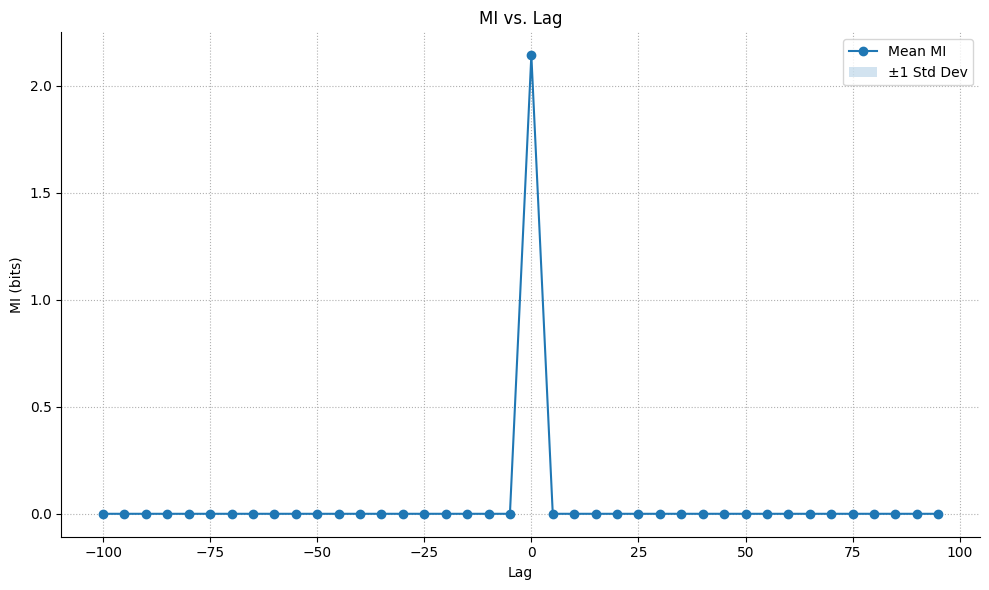

<Axes: title={'center': 'MI vs. Lag'}, xlabel='Lag', ylabel='MI (bits)'>

In [22]:
results_linear_lag.plot()

In [23]:
results_linear_lag.dataframe

,lag,mi_mean,mi_std
0,-100,-6.879306e-07,0.0
1,-95,-6.879306e-07,0.0
2,-90,-6.879306e-07,0.0
3,-85,-6.879306e-07,0.0
4,-80,-6.879306e-07,0.0
5,-75,-6.879306e-07,0.0
6,-70,-6.879306e-07,0.0
7,-65,-6.879306e-07,0.0
8,-60,-6.879306e-07,0.0
9,-55,-6.879306e-07,0.0


In [24]:
right_lag_size = results_linear_lag.dataframe.loc[results_linear_lag.dataframe['mi_mean'].idxmax()][0];
right_lag_size = int(right_lag_size)
display(right_lag_size)

/tmp/ipython-input-339308193.py:1: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  right_lag_size = results_linear_lag.dataframe.loc[results_linear_lag.dataframe['mi_mean'].idxmax()][0];


0

In [25]:
lag_range = range(-30, 30, 10)
window_range = list(range(22, 50, 2))
mi_results_2d = []

print("Starting 2D sweep...")
for lag in tqdm(lag_range, desc="Lag Sweep Progress"):
    # Manually shift the data for this lag
    x_aligned, y_aligned = nmi.utils._shift_data(c3_tensor, cp1_tensor, lag, 'continuous')

    # Now sweep over window sizes for this aligned data
    results = nmi.run(
        x_data=c3_tensor,
        y_data=cp1_tensor,
        mode='sweep',
        processor_type='continuous',
        processor_params={},
        base_params=base_params,
        sweep_grid={'window_size': window_range},
        n_workers=8,
        verbose=False
    )

    # Store the results
    for _, row in results.dataframe.iterrows():
        mi_results_2d.append({'lag': lag, 'window_size': row['window_size'], 'mi': row['mi_mean']})

print("2D sweep complete!")
results_df_2d = pd.DataFrame(mi_results_2d)

Starting 2D sweep...


Lag Sweep Progress:   0%|          | 0/6 [00:00<?, ?it/s]

2025-11-08 14:51:18 - neural_mi - WARNING - `processor_type` is deprecated. Use `processor_type_x` and `processor_type_y` instead.


2025-11-08 14:51:18 - neural_mi - WARNING - `processor_params` is deprecated. Use `processor_params_x` and `processor_params_y` instead.


2025-11-08 14:51:18 - neural_mi - INFO - Detected sweep over processor or lag parameters. Deferring data processing to workers.


INFO:neural_mi:Detected sweep over processor or lag parameters. Deferring data processing to workers.


2025-11-08 14:51:18 - neural_mi - INFO - Starting parameter sweep with 8 workers...


INFO:neural_mi:Starting parameter sweep with 8 workers...


Parameter Sweep Progress:   0%|          | 0/14 [00:00<?, ?task/s]

2025-11-08 14:53:20 - neural_mi - INFO - Parameter sweep finished.


INFO:neural_mi:Parameter sweep finished.


2025-11-08 14:53:20 - neural_mi - WARNING - `processor_type` is deprecated. Use `processor_type_x` and `processor_type_y` instead.


2025-11-08 14:53:20 - neural_mi - WARNING - `processor_params` is deprecated. Use `processor_params_x` and `processor_params_y` instead.


2025-11-08 14:53:20 - neural_mi - INFO - Detected sweep over processor or lag parameters. Deferring data processing to workers.


INFO:neural_mi:Detected sweep over processor or lag parameters. Deferring data processing to workers.


2025-11-08 14:53:20 - neural_mi - INFO - Starting parameter sweep with 8 workers...


INFO:neural_mi:Starting parameter sweep with 8 workers...


Parameter Sweep Progress:   0%|          | 0/14 [00:00<?, ?task/s]

2025-11-08 14:55:19 - neural_mi - INFO - Parameter sweep finished.


INFO:neural_mi:Parameter sweep finished.


2025-11-08 14:55:19 - neural_mi - WARNING - `processor_type` is deprecated. Use `processor_type_x` and `processor_type_y` instead.


2025-11-08 14:55:19 - neural_mi - WARNING - `processor_params` is deprecated. Use `processor_params_x` and `processor_params_y` instead.


2025-11-08 14:55:19 - neural_mi - INFO - Detected sweep over processor or lag parameters. Deferring data processing to workers.


INFO:neural_mi:Detected sweep over processor or lag parameters. Deferring data processing to workers.


2025-11-08 14:55:19 - neural_mi - INFO - Starting parameter sweep with 8 workers...


INFO:neural_mi:Starting parameter sweep with 8 workers...


Parameter Sweep Progress:   0%|          | 0/14 [00:00<?, ?task/s]

2025-11-08 14:57:20 - neural_mi - INFO - Parameter sweep finished.


INFO:neural_mi:Parameter sweep finished.


2025-11-08 14:57:20 - neural_mi - WARNING - `processor_type` is deprecated. Use `processor_type_x` and `processor_type_y` instead.


2025-11-08 14:57:20 - neural_mi - WARNING - `processor_params` is deprecated. Use `processor_params_x` and `processor_params_y` instead.


2025-11-08 14:57:20 - neural_mi - INFO - Detected sweep over processor or lag parameters. Deferring data processing to workers.


INFO:neural_mi:Detected sweep over processor or lag parameters. Deferring data processing to workers.


2025-11-08 14:57:20 - neural_mi - INFO - Starting parameter sweep with 8 workers...


INFO:neural_mi:Starting parameter sweep with 8 workers...


Parameter Sweep Progress:   0%|          | 0/14 [00:00<?, ?task/s]

2025-11-08 14:59:20 - neural_mi - INFO - Parameter sweep finished.


INFO:neural_mi:Parameter sweep finished.


2025-11-08 14:59:20 - neural_mi - WARNING - `processor_type` is deprecated. Use `processor_type_x` and `processor_type_y` instead.


2025-11-08 14:59:20 - neural_mi - WARNING - `processor_params` is deprecated. Use `processor_params_x` and `processor_params_y` instead.


2025-11-08 14:59:20 - neural_mi - INFO - Detected sweep over processor or lag parameters. Deferring data processing to workers.


INFO:neural_mi:Detected sweep over processor or lag parameters. Deferring data processing to workers.


2025-11-08 14:59:20 - neural_mi - INFO - Starting parameter sweep with 8 workers...


INFO:neural_mi:Starting parameter sweep with 8 workers...


Parameter Sweep Progress:   0%|          | 0/14 [00:00<?, ?task/s]

2025-11-08 15:01:21 - neural_mi - INFO - Parameter sweep finished.


INFO:neural_mi:Parameter sweep finished.


2025-11-08 15:01:21 - neural_mi - WARNING - `processor_type` is deprecated. Use `processor_type_x` and `processor_type_y` instead.


2025-11-08 15:01:21 - neural_mi - WARNING - `processor_params` is deprecated. Use `processor_params_x` and `processor_params_y` instead.


2025-11-08 15:01:21 - neural_mi - INFO - Detected sweep over processor or lag parameters. Deferring data processing to workers.


INFO:neural_mi:Detected sweep over processor or lag parameters. Deferring data processing to workers.


2025-11-08 15:01:21 - neural_mi - INFO - Starting parameter sweep with 8 workers...


INFO:neural_mi:Starting parameter sweep with 8 workers...


Parameter Sweep Progress:   0%|          | 0/14 [00:00<?, ?task/s]

2025-11-08 15:03:20 - neural_mi - INFO - Parameter sweep finished.


INFO:neural_mi:Parameter sweep finished.


2D sweep complete!


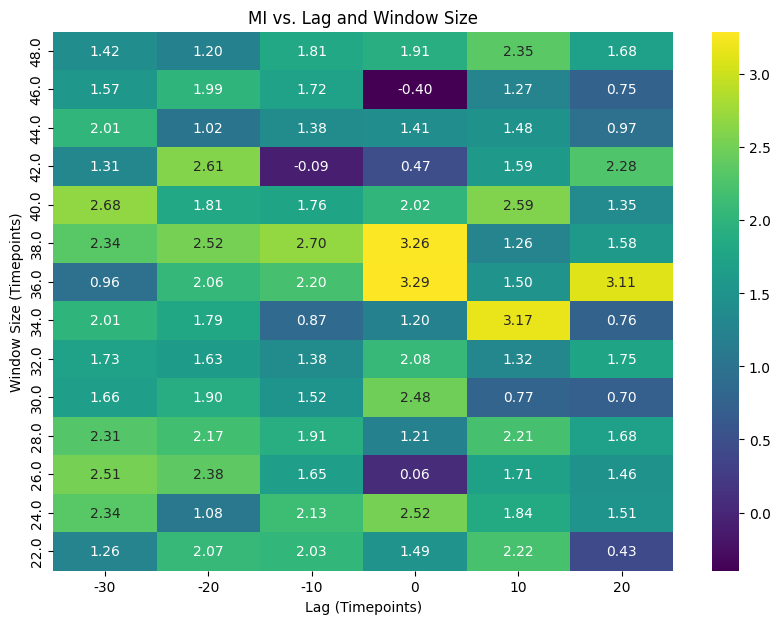

In [26]:
# Pivot the data for the heatmap
heatmap_data = results_df_2d.pivot(index='window_size', columns='lag', values='mi')

plt.figure(figsize=(10, 7))
sns.heatmap(heatmap_data, annot=True, cmap='viridis', fmt=".2f")
plt.title('MI vs. Lag and Window Size')
plt.xlabel('Lag (Timepoints)')
plt.ylabel('Window Size (Timepoints)')
plt.gca().invert_yaxis()
plt.show()

--- Causal Contour Analysis ---
MI at lag=0 rises at window_size = 24.0 (implies lag_true + history_true ≈ 24.0)

--- Parsimony Analysis (Significant MI > 2) ---
Shortest bridge is between [-20.  44.] on Causal Contour
and [-20.          42.76406024] on Significant MI Contour.
Bridge length: 1.24
Parsimonious Center: (lag=-20.0, window=43.4)
Parsimonious Radius: 6.18


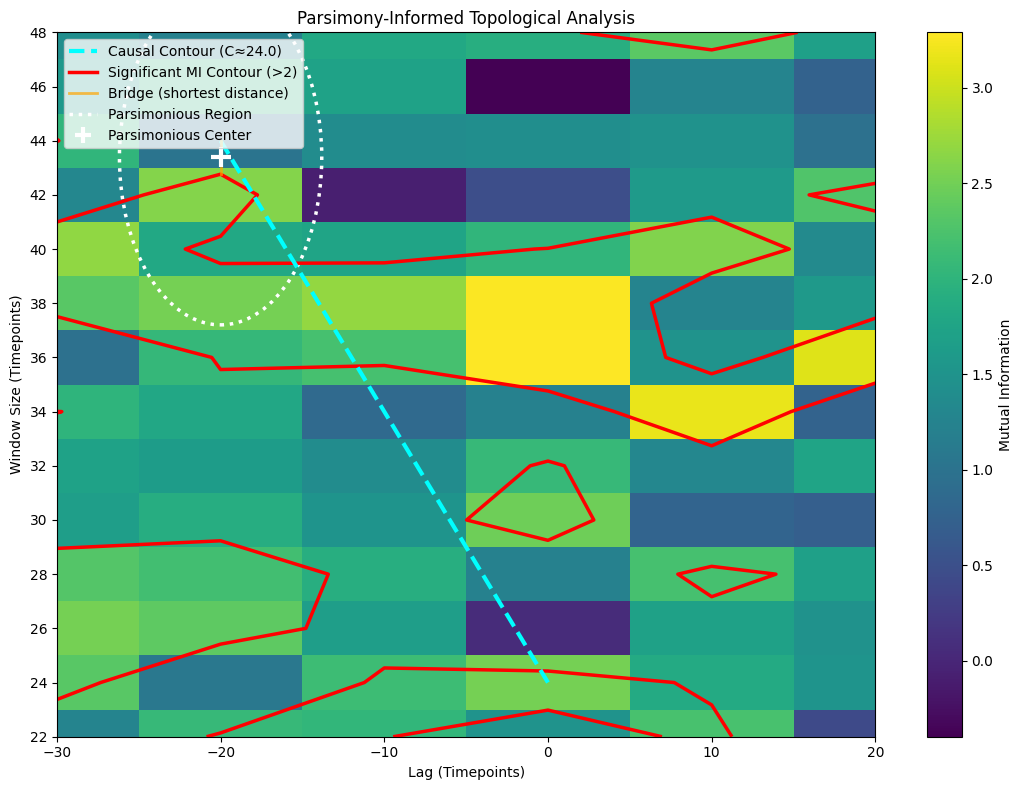

In [27]:
analyze_mi_heatmap(results_df_2d, absolute_mi_threshold=2, contour_rise_fraction=0.05, radius_multiplier=10)
#
#

In [28]:
right_window_and_lag_size = results_df_2d.loc[results.dataframe['mi_mean'].idxmax()][0];
right_window_size = int(right_window_size)
display(right_window_size)
# filter negative ones
#

/tmp/ipython-input-2883941279.py:1: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  right_window_and_lag_size = results_df_2d.loc[results.dataframe['mi_mean'].idxmax()][0];


25

In [29]:
import json

path = "/content/gdrive/MyDrive/Colab Notebooks/NeuralMI_tutorial.ipynb"  # change to your notebook name

with open(path, 'r', encoding='utf-8') as f:
    nb = json.load(f)

if 'widgets' in nb.get('metadata', {}):
    del nb['metadata']['widgets']

with open(path, 'w', encoding='utf-8') as f:
    json.dump(nb, f, indent=2)
